In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB

In [3]:
# Set random seed
random.seed(1337)

In [4]:
# Import seed
data = pd.read_csv('../data/data.csv')

In [5]:
data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [6]:
# Check for null values
data.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [7]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [8]:
# Split data into train (0.8), validation (0.2), and test (0.2) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(data.drop(target_cols, axis=1), data[target_cols], test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25)

In [9]:
# Print value counts for train targets
for col in target_cols:
    print(y_train[col].value_counts())

0    86618
1     9124
Name: toxic, dtype: int64
0    94796
1      946
Name: severe_toxic, dtype: int64
0    90749
1     4993
Name: obscene, dtype: int64
0    95466
1      276
Name: threat, dtype: int64
0    91085
1     4657
Name: insult, dtype: int64
0    94927
1      815
Name: identity_hate, dtype: int64


In [10]:
# Print value counts for validation targets
for col in target_cols:
    print(y_val[col].value_counts())

0    28853
1     3061
Name: toxic, dtype: int64
0    31597
1      317
Name: severe_toxic, dtype: int64
0    30183
1     1731
Name: obscene, dtype: int64
0    31811
1      103
Name: threat, dtype: int64
0    30309
1     1605
Name: insult, dtype: int64
0    31626
1      288
Name: identity_hate, dtype: int64


In [11]:
# Print value counts for test targets
for col in target_cols:
    print(y_test[col].value_counts())

0    28806
1     3109
Name: toxic, dtype: int64
0    31583
1      332
Name: severe_toxic, dtype: int64
0    30190
1     1725
Name: obscene, dtype: int64
0    31816
1       99
Name: threat, dtype: int64
0    30300
1     1615
Name: insult, dtype: int64
0    31613
1      302
Name: identity_hate, dtype: int64


In [12]:
# Print value counts for train+validation targets
for col in target_cols:
    print(y_train_val[col].value_counts())

0    115471
1     12185
Name: toxic, dtype: int64
0    126393
1      1263
Name: severe_toxic, dtype: int64
0    120932
1      6724
Name: obscene, dtype: int64
0    127277
1       379
Name: threat, dtype: int64
0    121394
1      6262
Name: insult, dtype: int64
0    126553
1      1103
Name: identity_hate, dtype: int64


In [13]:
predicted = pd.DataFrame()
for col in target_cols:
    predicted[col] = [0]*y_test.shape[0]
predicted.head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [14]:
# Compute (trivially) ROC-AUC when predicting majority class
auc_average = []
for col in target_cols:
    fpr, tpr, threshold = roc_curve(y_test[col], predicted[col])
    auc_average.append(auc(fpr, tpr))
print('ROC-AUC When Predicting Majority Class (all zeros) =', np.mean(auc_average))

ROC-AUC When Predicting Majority Class (all zeros) = 0.5


In [15]:
# Fit Count Vectorizer
countvec = CountVectorizer(analyzer='word', lowercase=False, max_features=1000)
countvec.fit(X_train_val['comment_text'])

# Fit TF-IDF Vectorizer
tfidf = TfidfVectorizer(analyzer='word', lowercase=False, max_features=1000)
tfidf.fit(X_train_val['comment_text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [16]:
# Transform data as per Count Vectorizer
X_train_val_countvec = countvec.transform(X_train_val['comment_text'])
X_test_countvec = countvec.transform(X_test['comment_text'])

# Transform data as per TF-IDF Vectorizer
X_train_val_tfidf = tfidf.transform(X_train_val['comment_text'])
X_test_tfidf = tfidf.transform(X_test['comment_text'])

In [17]:
# Fit individual BernoulliNB models for each target with Count Vectorizer
bnb_countvec = BinaryRelevance(BernoulliNB())
bnb_countvec.fit(X_train_val_countvec, y_train_val)
predictions_bnb_countvec = bnb_countvec.predict_proba(X_test_countvec)

# Fit individual GaussianNB models for each target with Count Vectorizer
gnb_countvec = BinaryRelevance(GaussianNB())
gnb_countvec.fit(X_train_val_countvec, y_train_val)
predictions_gnb_countvec = gnb_countvec.predict_proba(X_test_countvec)

# Fit individual GaussianNB models for each target with TF-IDF Vectorizer
gnb_tfidf = BinaryRelevance(GaussianNB())
gnb_tfidf.fit(X_train_val_tfidf, y_train_val)
predictions_gnb_tfidf = gnb_tfidf.predict_proba(X_test_tfidf)

In [18]:
# Predict probabilities of each class for Count Vectorizer (BernoulliNB)
probabilities_bnb_countvec = np.squeeze(np.asarray(predictions_bnb_countvec.todense()))

# Predict probabilities of each class for Count Vectorizer and TF-IDF Vectorizer (GaussianNB)
probabilities_gnb_countvec = np.squeeze(np.asarray(predictions_gnb_countvec.todense()))
probabilities_gnb_tfidf = np.squeeze(np.asarray(predictions_gnb_tfidf.todense()))

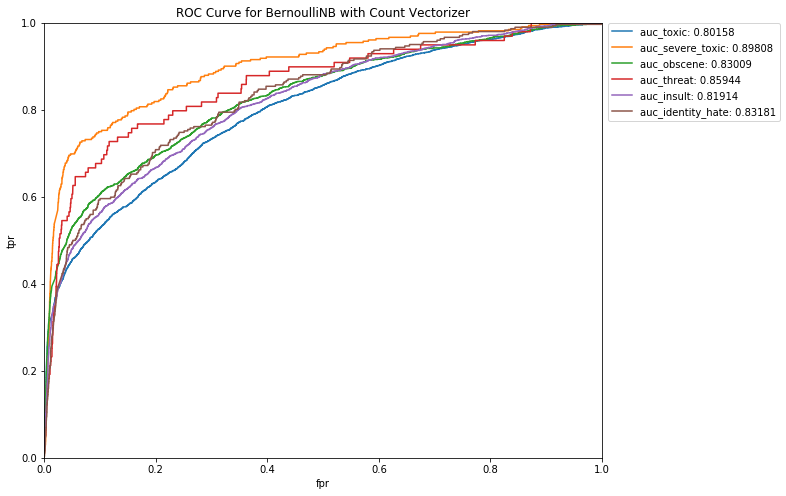

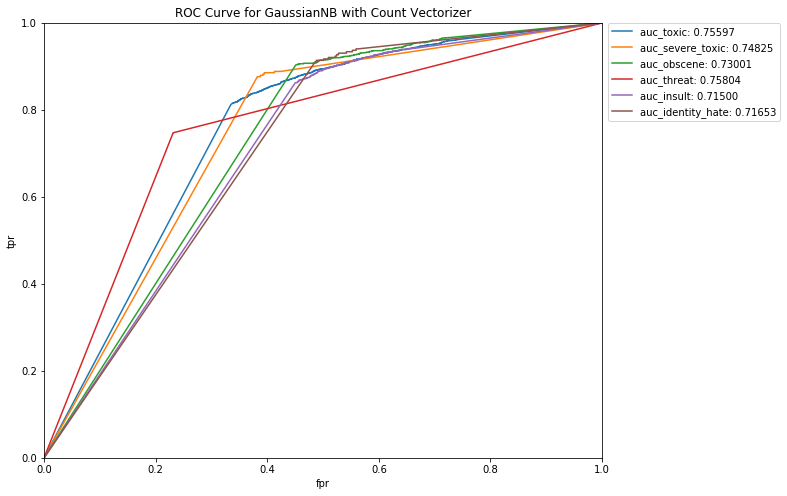

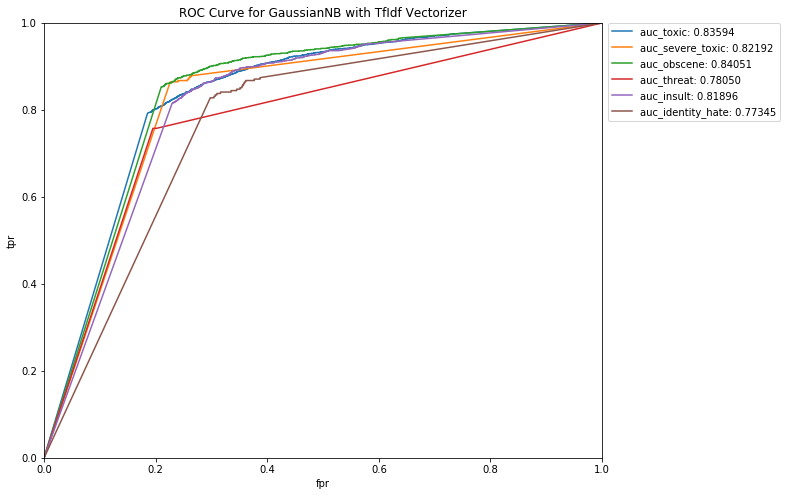

In [19]:
# Compute ROC-AUC values of each class for Count Vectorizer (BernoulliNB)
auc_bnb_countvec = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_bnb_countvec[:,i])
    auc_value = auc(fpr, tpr)
    auc_bnb_countvec.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for BernoulliNB with Count Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()
    
# Compute ROC-AUC values of each class for Count Vectorizer (GaussianNB)
auc_gnb_countvec = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_gnb_countvec[:,i])
    auc_value = auc(fpr, tpr)
    auc_gnb_countvec.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for GaussianNB with Count Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# Compute ROC-AUC values of each class for TfIdf Vectorizer (GaussianNB)
auc_gnb_tfidf = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_gnb_tfidf[:,i])
    auc_value = auc(fpr, tpr)
    auc_gnb_tfidf.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for GaussianNB with TfIdf Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

In [21]:
# Get mean column-wise ROC-AUC values
print('ROC-AUC for BernoulliNB with Count Vectorizer =', np.mean(auc_bnb_countvec))
print('ROC-AUC for GaussianNB with Count Vectorizer =', np.mean(auc_gnb_countvec))
print('ROC-AUC for GaussianNB with TfIdf Vectorizer =', np.mean(auc_gnb_tfidf))

ROC-AUC for BernoulliNB with Count Vectorizer = 0.8400226956976145
ROC-AUC for GaussianNB with Count Vectorizer = 0.7372994223348425
ROC-AUC for GaussianNB with TfIdf Vectorizer = 0.811879958211136
